# N-Body Gravitationally Interacting System

Let's try doing something more complicated: N-body dynamics. As the name implies, we have $N$ interacting bodies where the interactions are mediated by some forces.

For this notebook, we'll look at gravitational interactions. It should be mentioned that N-body interactions are generally slow to compute because every body interacts with every other body and thus you have to compute the force $N(N-1)$, $\frac{N(N-1)}{2}$ times if the force is symmetric as in our case, which scales really poorly. There are methods to overcome this, but are not in the scope of this notebook as we'll be looking at $N\sim10$.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import desolver as de
import numpy as np

Using `autoray` backend


## Specifying the Dynamical System

Writing out the dynamical equations will take a bit more work, but we'll start from Newton's Law of Gravitation and build from there.

So, Newton's Law of Gravitation states the gravitational force exerted by one body on another is

$$
\vec F_{ij} = G\frac{m_i m_j}{|\vec r_j - \vec r_i|^3} (\vec r_j - \vec r_i)
$$

where $G$ is the gravitational constant, $m_i$ and $m_j$ are the masses of the two bodies, and $\vec r_i$ and $\vec r_j$ are the position vectors of the two bodies.

Note that this is symmetric in terms of magnitude and merely the direction is flipped when we swap $i$ and $j$, i.e. $\vec F_{ij} = -\vec F_{ji}$. This is where the factor of $\frac{1}{2}$ comes from the in the number of computations required.

This is not sufficient to compute the actual dynamics, we must find the force on a single body from all the other bodies. To do this, we simply add the forces of every other body in the simulation thus the force is

$$
\vec F_i = \sum_{j\neq i}F_{ij}
$$

You'll notice that we sum over $i\neq j$ thus there are $(N-1)$ $F_{ij}$ terms to add. This is where the factor of $(N-1)$ in the number of computations comes from, and since we do it for every single body, we do this computation $N$ times thus the factor of $N$ is explained as well.

This is all well and good, but how do we write this? Well, `desolver` makes that part much simpler. Unlike solve_ivp, my equation representation is not required to be a single vector at any stage, thus I can easily have an array of shape `(N, 6)` to represent the state vectors of each body. This will also allow me to easily take advantage of `numpy` broadcasting semantics.

In [2]:
def Fij(ri, rj, G):
    rel_r = rj - ri
    return G*(1/np.linalg.norm(rel_r, ord=2)**3)*rel_r

def rhs(t, state, masses, G):
    total_acc = np.zeros_like(state)
    
    for idx, (ri, mi) in enumerate(zip(state, masses)):
        for jdx, (rj, mj) in enumerate(zip(state[idx+1:], masses[idx+1:])):
            partial_force = Fij(ri[:3], rj[:3], G)
            total_acc[idx, 3:]       += partial_force * mj
            total_acc[idx+jdx+1, 3:] -= partial_force * mi
    
    total_acc[:, :3] = state[:, 3:]
    
    return total_acc

NOTE: The line `total_acc[:, :3] -= (np.sum(total_acc[:, :3]*masses[:, None], axis=0) / np.sum(masses))` is useful when we want to look at how the objects behave relative to the centre of mass. Generally this would be relative to the Sun if the other bodies are the planets in our Solar System given that most of the mass in our Solar System is concentrated at the Sun.

### Hénon Units

Now we cannot use the equations in this form because they encompass a very large scale of values ranging from $10^{-11}$ for the gravitational constant to $10^{30}$ for the mass of the sun. Thus we will non-dimensionalise the system by measuring all the lengths by $1AU = 149597871km$, the masses by $M_\bigodot = 1.989\times 10^{30}kg$, and the time in $1yr$.

In these units, the gravitational constant becomes $G = 4\pi^2$. Using the constants defined in the next cell, units in SI can be converted to units in our system.

In [ ]:
Msun = 1.98847*10**30   ## Mass of the Sun, kg
AU   = 149597871e3      ## 1 Astronomical Unit, m
year = 365.25*24*3600   ## 1 year, s
G    = 4*np.pi**2       ## in solar masses, AU, years
V    = np.sqrt(G)        ## Speed scale corresponding to the orbital speed required for a circular orbit at 1AU with a period of 1yr

I've added 3 massive bodies at the ends of a scalene triangle

In [4]:
initial_state = np.array([
    [0.0,   0.0,                1.0,  0.0,                  -1.0,    0.0],
    [1.0,   0.0,                0.0,  0.0,                   1.0,    0.0],
    [0.25,  0.9682458365518543, 0.0,  0.9682458365518543*0, -0.25*0, 0.0],
    [-0.5, -0.8660254037844386, 0.0, -0.8660254037844386*0,  0.5*0,  0.0],
], dtype=np.longdouble)

masses = np.array([
    1,
    1,
    1,
    1,
], dtype=np.longdouble)

rhs(0.0, initial_state, masses, G)

array([[  0.        ,  -1.        ,   0.        ,  10.4682963 ,
          1.42676504, -41.8731852 ],
       [  0.        ,   1.        ,   0.        , -41.47116241,
         14.22721674,  13.9577284 ],
       [  0.        ,  -0.        ,   0.        ,   8.82285763,
        -43.62661768,  13.9577284 ],
       [ -0.        ,   0.        ,   0.        ,  22.18000848,
         27.97263591,  13.9577284 ]], dtype=float128)

## The Numerical Integration

We will use the 14th order Runge-Kutta integrator to integrate our system with tolerances of $10^{-14}$ which should give fairly accurate results despite the very complicated trajectories of each body.

Although symplectic integrators are great for conserving the energy, we prefer an adaptive integrator due to the fact that the bodies have close encounters which require much smaller steps to resolve. If we were to use small step sizes at all times, we'd be wasting computation whenever the bodies are far from each other. This leads us to pick an adaptive Runge-Kutta method.

In [5]:
a = de.OdeSystem(rhs, y0=initial_state, dense_output=True, t=(0, 2.0), dt=0.00001, rtol=de.backend.tol_epsilon(initial_state.dtype), atol=de.backend.tol_epsilon(initial_state.dtype), constants=dict(G=G, masses=masses))
a.method = "RK1412"

In [6]:
a.integrate()

/home/vscode/.local/share/hatch/env/virtual/desolver/Eduj4EGQ/dev/lib/python3.12/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args, **kwargs)


<Figure size 1600x1600 with 0 Axes>

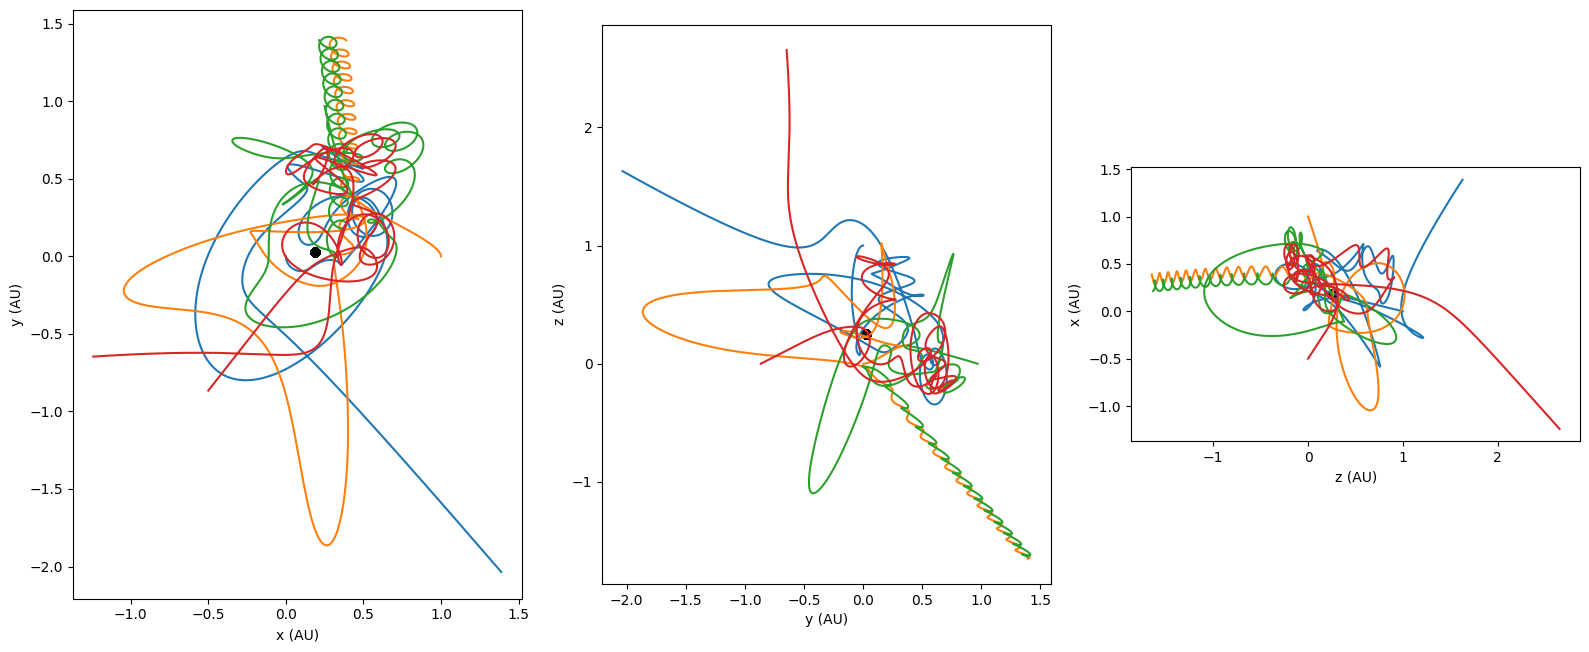

In [7]:
fig = plt.figure(figsize=(16,16))

com_motion = np.sum(a.y[:, :, :] * masses[None, :, None], axis=1) / np.sum(masses)

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(131, aspect=1)
ax2 = fig.add_subplot(132, aspect=1)
ax3 = fig.add_subplot(133, aspect=1)

ax1.set_xlabel("x (AU)")
ax1.set_ylabel("y (AU)")
ax2.set_xlabel("y (AU)")
ax2.set_ylabel("z (AU)")
ax3.set_xlabel("z (AU)")
ax3.set_ylabel("x (AU)")

for i in range(a.y.shape[1]):
    ax1.plot(a.y[:, i, 0], a.y[:, i, 1], color=f"C{i}")
    ax2.plot(a.y[:, i, 1], a.y[:, i, 2], color=f"C{i}")
    ax3.plot(a.y[:, i, 2], a.y[:, i, 0], color=f"C{i}")
    
ax1.scatter(com_motion[:, 0], com_motion[:, 1], color='k')
ax2.scatter(com_motion[:, 1], com_motion[:, 2], color='k')
ax3.scatter(com_motion[:, 2], com_motion[:, 0], color='k')

plt.tight_layout()

## Close Encounters and Event Detection

Suppose we were interested in finding when two bodies are near each other, how would we do it? We could integrate the system, compare the distances of each body with one another and whenever they were below some threshold we can mark that time. But this is inherently inexact because maybe the actual closest point occurs between two timesteps and our adaptive integrator, being extra intelligent, did not require stepping through that exact point to find the closest encounter.

So what can we do? We can use **Event Detection**! Event detection is where we find when some event occurs during a numerical integration and localise on that event.

We need to first create a function that will tell us when two objects are nearby. We'll define nearby as whenever the two bodies are within half of each other's Hill sphere. The Hill radius is computed as $a\sqrt[3]{\frac{m}{3M_{total}}}$ where we assume that the eccentricity is unimportant and $a$ will be the distance from the centre of mass.

In [8]:
def close_encounter(t, state, masses, G):
    distances_between_bodies = []
    
    total_mass     = np.sum(masses)
    center_of_mass = np.sum(state[:, :3] * masses[:, None], axis=1) / total_mass
    
    com_distances  = np.linalg.norm(state[:, :3] - center_of_mass[:, None], axis=1)
    hill_radii     = com_distances * np.pow(masses/(3*total_mass), 1/3)
    
    for idx,ri in enumerate(state[:, :3]):
        for jdx, rj in enumerate(state[idx+1:, :3]):
            distances_between_bodies.append(np.linalg.norm(ri - rj) - np.min([hill_radii[idx], hill_radii[jdx]])/2.0)
    
    return np.min(distances_between_bodies)

In [9]:
a.reset()
a.integrate(events=close_encounter)

<Figure size 1600x1600 with 0 Axes>

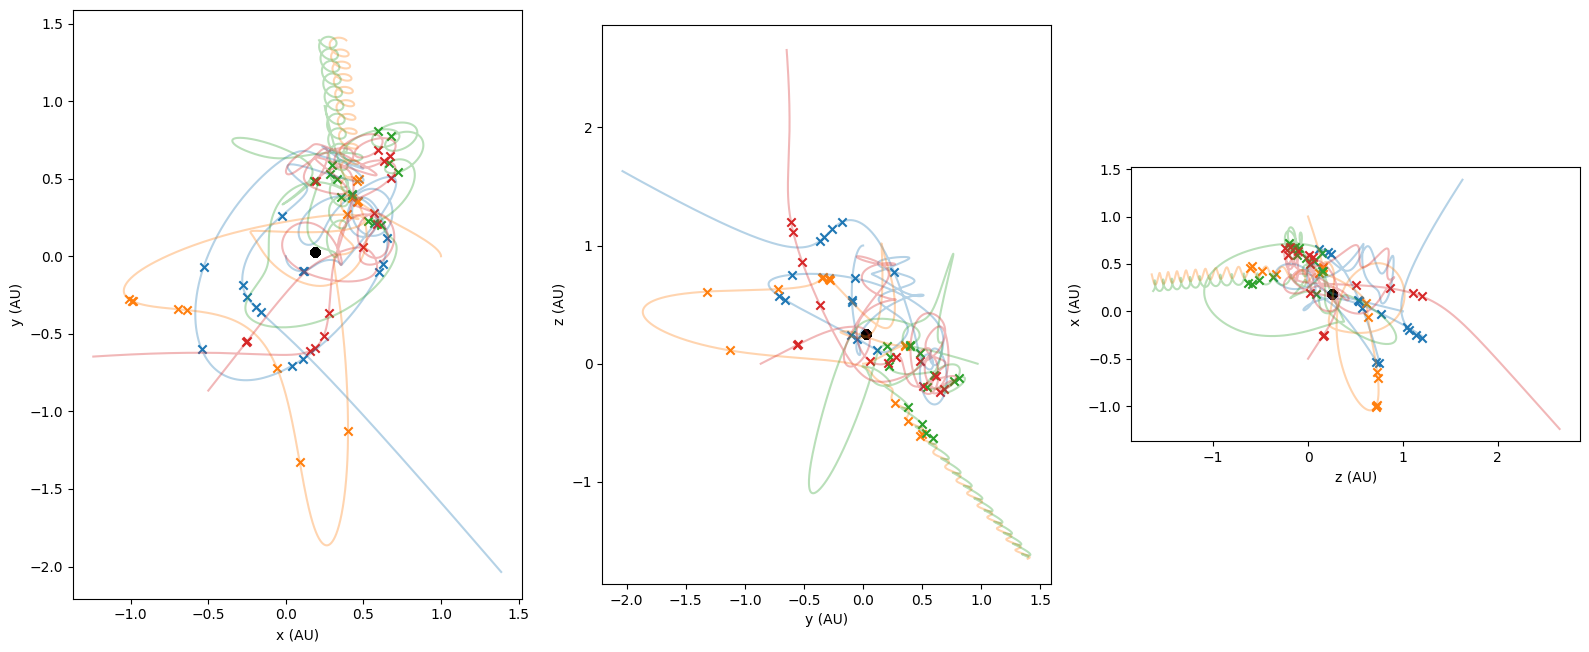

In [10]:
fig = plt.figure(figsize=(16,16))

com_motion = np.sum(a.y[:, :, :] * masses[None, :, None], axis=1) / np.sum(masses)

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(131, aspect=1)
ax2 = fig.add_subplot(132, aspect=1)
ax3 = fig.add_subplot(133, aspect=1)

ax1.set_xlabel("x (AU)")
ax1.set_ylabel("y (AU)")
ax2.set_xlabel("y (AU)")
ax2.set_ylabel("z (AU)")
ax3.set_xlabel("z (AU)")
ax3.set_ylabel("x (AU)")

for i in range(a.y.shape[1]):
    ax1.plot(a.y[:, i, 0], a.y[:, i, 1], color=f"C{i}", alpha=0.33)
    ax2.plot(a.y[:, i, 1], a.y[:, i, 2], color=f"C{i}", alpha=0.33)
    ax3.plot(a.y[:, i, 2], a.y[:, i, 0], color=f"C{i}", alpha=0.33)
    for j in a.events:
        ax1.scatter(j.y[i, 0], j.y[i, 1], c=f"C{i}", marker='x', alpha=1.0)
        ax2.scatter(j.y[i, 1], j.y[i, 2], c=f"C{i}", marker='x', alpha=1.0)
        ax3.scatter(j.y[i, 2], j.y[i, 0], c=f"C{i}", marker='x', alpha=1.0)
    
ax1.scatter(com_motion[:, 0], com_motion[:, 1], color='k')
ax2.scatter(com_motion[:, 1], com_motion[:, 2], color='k')
ax3.scatter(com_motion[:, 2], com_motion[:, 0], color='k')

plt.tight_layout()

We see that there are many close encounters and furthermore, the encounters are not restricted to any particular pairs of bodies, but sometimes happen with three bodies simultaneously. We will see this better in the next section where we look at an animation of the bodies.

## An Animated View of the Bodies

The following code, although long, shows how to set up a matplotlib animation showing the bodies in all three planes and the close encounters they experience.

In [11]:
from matplotlib import animation, rc

# set to location of ffmpeg to get animations working
# For Linux or Mac
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# For Windows
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\ProgramData\\chocolatey\\bin\\ffmpeg.exe'

from IPython.display import HTML

In [12]:
%%capture

# This magic command prevents the creation of a static figure image so that we can view the animation in the next cell
t          = a.t
all_states = a.y
planets    = [all_states[:, i, :] for i in range(all_states.shape[1])]
com_motion = np.sum(all_states * masses[None, :, None], axis=1) / np.sum(masses)

plt.ioff()

fig = plt.figure(figsize=(16,8))
ax1  = fig.add_subplot(131, aspect=1)
ax2  = fig.add_subplot(132, aspect=1)
ax3  = fig.add_subplot(133, aspect=1)

ax1.set_xlabel("x (AU)")
ax1.set_ylabel("y (AU)")
ax2.set_xlabel("y (AU)")
ax2.set_ylabel("z (AU)")
ax3.set_xlabel("z (AU)")
ax3.set_ylabel("x (AU)")

xlims = np.abs(a.y[:, :, 0]).max()
ylims = np.abs(a.y[:, :, 1]).max()
zlims = np.abs(a.y[:, :, 2]).max()

ax1.set_xlim(-xlims-0.25, xlims+0.25)
ax2.set_xlim(-ylims-0.25, ylims+0.25)
ax3.set_xlim(-zlims-0.25, zlims+0.25)

ax1.set_ylim(-ylims-0.25, ylims+0.25)
ax2.set_ylim(-zlims-0.25, zlims+0.25)
ax3.set_ylim(-xlims-0.25, xlims+0.25)

planets_pos_xy = []
planets_pos_yz = []
planets_pos_zx = []

planets_xy     = []
planets_yz     = []
planets_zx     = []

com_xy,        = ax1.plot([], [], color='k', linestyle='', marker='o', markersize=5.0, zorder=10)
com_yz,        = ax2.plot([], [], color='k', linestyle='', marker='o', markersize=5.0, zorder=10)
com_zx,        = ax3.plot([], [], color='k', linestyle='', marker='o', markersize=5.0, zorder=10)

event_counter = 0

close_encounter_xy = []
close_encounter_yz = []
close_encounter_zx = []

for i in range(len(planets)):
    close_encounter_xy.append(ax1.plot([], [], color=f"k", marker='x', markersize=3.0, linestyle='', zorder=9)[0])
    close_encounter_yz.append(ax2.plot([], [], color=f"k", marker='x', markersize=3.0, linestyle='', zorder=9)[0])
    close_encounter_zx.append(ax3.plot([], [], color=f"k", marker='x', markersize=3.0, linestyle='', zorder=9)[0])

for i in range(a.y.shape[1]):
    planets_xy.append(ax1.plot([], [], color=f"C{i}", zorder=8)[0])
    planets_yz.append(ax2.plot([], [], color=f"C{i}", zorder=8)[0])
    planets_zx.append(ax3.plot([], [], color=f"C{i}", zorder=8)[0])
    planets_pos_xy.append(ax1.plot([], [], color=f"C{i}", linestyle='', marker='.', zorder=8)[0])
    planets_pos_yz.append(ax2.plot([], [], color=f"C{i}", linestyle='', marker='.', zorder=8)[0])
    planets_pos_zx.append(ax3.plot([], [], color=f"C{i}", linestyle='', marker='.', zorder=8)[0])
    
def init():
    global event_counter
    for i in range(len(planets)):
        planets_xy[i].set_data([], [])
        planets_yz[i].set_data([], [])
        planets_zx[i].set_data([], [])
        planets_pos_xy[i].set_data([], [])
        planets_pos_yz[i].set_data([], [])
        planets_pos_zx[i].set_data([], [])
        
    com_xy.set_data([], [])
    com_yz.set_data([], [])
    com_zx.set_data([], [])
    
    for i in range(len(planets)):
        close_encounter_xy[i].set_data([a.events[event_counter].y[i, 0]], [a.events[event_counter].y[i, 1]])
        close_encounter_yz[i].set_data([a.events[event_counter].y[i, 1]], [a.events[event_counter].y[i, 2]])
        close_encounter_zx[i].set_data([a.events[event_counter].y[i, 2]], [a.events[event_counter].y[i, 0]])
    
    return tuple(planets_xy + planets_yz + planets_zx + planets_pos_xy + planets_pos_yz + planets_pos_zx + [com_xy, com_yz, com_zx] + [close_encounter_xy, close_encounter_yz, close_encounter_zx])

def animate(frame_num):
    global event_counter
    for i in range(len(planets)):
        planets_xy[i].set_data(planets[i][max(frame_num-5, 0):frame_num, 0], planets[i][max(frame_num-5, 0):frame_num, 1])
        planets_yz[i].set_data(planets[i][max(frame_num-5, 0):frame_num, 1], planets[i][max(frame_num-5, 0):frame_num, 2])
        planets_zx[i].set_data(planets[i][max(frame_num-5, 0):frame_num, 2], planets[i][max(frame_num-5, 0):frame_num, 0])
        planets_pos_xy[i].set_data(planets[i][frame_num:frame_num+1, 0], planets[i][frame_num:frame_num+1, 1])
        planets_pos_yz[i].set_data(planets[i][frame_num:frame_num+1, 1], planets[i][frame_num:frame_num+1, 2])
        planets_pos_zx[i].set_data(planets[i][frame_num:frame_num+1, 2], planets[i][frame_num:frame_num+1, 0])
        
    com_xy.set_data(com_motion[frame_num:frame_num+1, 0], com_motion[frame_num:frame_num+1, 1])
    com_yz.set_data(com_motion[frame_num:frame_num+1, 1], com_motion[frame_num:frame_num+1, 2])
    com_zx.set_data(com_motion[frame_num:frame_num+1, 2], com_motion[frame_num:frame_num+1, 0])
    
    if t[frame_num] >= a.events[event_counter].t and event_counter + 1 < len(a.events):
        event_counter += 1
        for i in range(len(planets)):
            close_encounter_xy[i].set_data([a.events[event_counter].y[i, 0]], [a.events[event_counter].y[i, 1]])
            close_encounter_yz[i].set_data([a.events[event_counter].y[i, 1]], [a.events[event_counter].y[i, 2]])
            close_encounter_zx[i].set_data([a.events[event_counter].y[i, 2]], [a.events[event_counter].y[i, 0]])
    
    return tuple(planets_xy + planets_yz + planets_zx + planets_pos_xy + planets_pos_yz + planets_pos_zx + [com_xy, com_yz, com_zx] + [close_encounter_xy, close_encounter_yz, close_encounter_zx])

ani = animation.FuncAnimation(fig, animate, list(range(1, len(t))),
                              interval=600./60., blit=False, init_func=init)

rc('animation', html='html5')

# Uncomment to save an mp4 video of the animation
# ani.save('Nbodies.mp4', fps=60)

Here we see that the animation slows down whenever the bodies come close to each other and this is due to the adaptive timestepping of the numerical integration which takes more steps whenever there is a close encounter. Each "**x**" marks the point of all the bodies whenever there is a close encounter.

Additionally, it's interesting to see that the center of mass (the large black dot in the center) does not move at all. Since we initialised the system with zero momentum, this is to be expected given that we are not doing anything to violate momentum conservation, but it is good to see that our numerical integration also respects this behaviour.

In [13]:
display(ani)